In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import image as img
import warnings
from PIL import Image
warnings.filterwarnings('ignore')
import torch
import torchvision
from torch.utils import data
from torchvision import transforms

In [3]:
import os
path="../input/gtsrb-german-traffic-sign"
for directory in os.listdir(path):
    print(directory)

Meta
meta
Meta.csv
Train.csv
Test.csv
Test
test
Train
train


In [4]:
# printing types of classes
train_path = path +'/'+ 'train'
for directory in os.listdir(train_path):
    print(directory,end=" ")

7 17 19 22 2 35 23 10 5 36 20 27 41 39 32 25 42 8 38 12 0 31 34 18 28 16 13 26 15 3 1 30 14 4 9 21 40 6 11 37 33 29 24 

In [5]:
df_train = pd.read_csv("../input/gtsrb-german-traffic-sign/Train.csv")
print("Number of training samples {}".format(df_train.shape))
df_train.head()

Number of training samples (39209, 8)


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


# From the diagram below average dimension of image is approximately 50 X 50

In [6]:
df_train.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000


In [7]:
numClasses = 43

fig, axs = plt.subplots(9,5, figsize=(100,150))
fig.tight_layout(h_pad = 20)
for i in range(numClasses):
    row = i // 5
    col = i % 5
    
    imgName = '../input/gtsrb-german-traffic-sign/Meta/' + str(i) + ".png"
    img = Image.open(imgName)
    axs[row, col].imshow(img)
    axs[row, col].set_title(str(i), fontsize=75)

plt.savefig("classes.png", bbox_inches = 'tight', pad_inches=0.5)

# plotting number of samples in each class

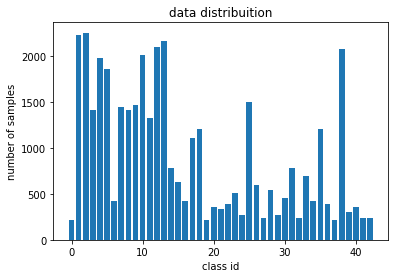

In [8]:
value_counts = df_train['ClassId'].value_counts()
class_id = (value_counts.index).to_numpy()
num_samples = (value_counts).to_numpy()
plt.xlabel('class id')
plt.ylabel('number of samples')
plt.title('data distribuition')
plt.bar(class_id,num_samples)
plt.show()

# transforming images to 112 X 112 and adding transformations

In [9]:
# Defining hyperparameters

BATCH_SIZE = 256
learning_rate = 0.001
EPOCHS = 15
numClasses = 43

train_transformations = transforms.Compose([
    transforms.Resize((112,112)),
    transforms.ToTensor()
])

In [10]:
# splitting train data into train and validation splits

In [11]:
train_data = torchvision.datasets.ImageFolder(root = train_path, transform = train_transformations)

# Divide data into training and validation (0.8 and 0.2)
ratio = 0.8
n_train_examples = int(len(train_data) * ratio)
n_val_examples = len(train_data) - n_train_examples

train_data, val_data = data.random_split(train_data, [n_train_examples, n_val_examples])

print(f"Number of training samples = {len(train_data)}")
print(f"Number of validation samples = {len(val_data)}")


Number of training samples = 31367
Number of validation samples = 7842


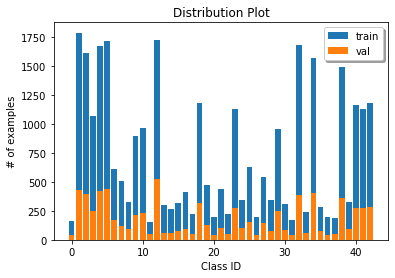

In [12]:
# Plot histogram for training and validation data

train_hist = [0]*numClasses
for i in train_data.indices:
    tar = train_data.dataset.targets[i]
    train_hist[tar] += 1
    
val_hist = [0]*numClasses
for i in val_data.indices:
    tar = val_data.dataset.targets[i]
    val_hist[tar] += 1

plt.bar(range(numClasses), train_hist, label="train")
plt.bar(range(numClasses), val_hist, label="val")
legend = plt.legend(loc='upper right', shadow=True)
plt.title("Distribution Plot")
plt.xlabel("Class ID")
plt.ylabel("# of examples")

plt.savefig("train_val_split.png", bbox_inches = 'tight', pad_inches=0.5)

In [13]:
# Create data loader for training and validation

train_loader = data.DataLoader(train_data, shuffle=True, batch_size = BATCH_SIZE)
val_loader = data.DataLoader(val_data, shuffle=True, batch_size = BATCH_SIZE)


In [14]:
# Function to count the number of parameters in the model

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [15]:
import torch.nn as nn

class AlexnetTS(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*7*7, 1000),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.5),
            nn.Linear(in_features=1000, out_features=256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256, output_dim)
            )
        
    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [16]:
model = AlexnetTS(numClasses)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 15,063,891 trainable parameters


In [17]:
from torch import optim
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [18]:
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
print(model)

AlexnetTS(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=12544, out_features=1000, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5,

In [19]:
!pip install torchsummary
from torchsummary import summary
print(summary(model, (3, 112, 112))) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           1,792
         MaxPool2d-2           [-1, 64, 28, 28]               0
              ReLU-3           [-1, 64, 28, 28]               0
            Conv2d-4          [-1, 192, 28, 28]         110,784
         MaxPool2d-5          [-1, 192, 14, 14]               0
              ReLU-6          [-1, 192, 14, 14]               0
            Conv2d-7          [-1, 384, 14, 14]         663,936
              ReLU-8          [-1, 384, 14, 14]               0
            Conv2d-9          [-1, 256, 14, 14]         884,992
             ReLU-10          [-1, 256, 14, 14]               0
           Conv2d-11          [-1, 256, 14, 14]         590,080
        MaxPool2d-12            [-1, 256, 7, 7]               0
             ReLU-13            [-1, 256, 7, 7]               0
          Dropout-14                [-1

In [20]:
print("Model's state dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
print("")


Model's state dict:
features.0.weight 	 torch.Size([64, 3, 3, 3])
features.0.bias 	 torch.Size([64])
features.3.weight 	 torch.Size([192, 64, 3, 3])
features.3.bias 	 torch.Size([192])
features.6.weight 	 torch.Size([384, 192, 3, 3])
features.6.bias 	 torch.Size([384])
features.8.weight 	 torch.Size([256, 384, 3, 3])
features.8.bias 	 torch.Size([256])
features.10.weight 	 torch.Size([256, 256, 3, 3])
features.10.bias 	 torch.Size([256])
classifier.1.weight 	 torch.Size([1000, 12544])
classifier.1.bias 	 torch.Size([1000])
classifier.4.weight 	 torch.Size([256, 1000])
classifier.4.bias 	 torch.Size([256])
classifier.6.weight 	 torch.Size([43, 256])
classifier.6.bias 	 torch.Size([43])



In [21]:
# Print optimizer details

print("Optimizer details:")
print(optimizer)
print("")

Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)



In [22]:
# Function to calculate accuracy

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc



In [23]:
def train(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    # Train the model
    model.train()
    
    for (images, labels) in loader:
        images = images.cuda()
        labels = labels.cuda()
        
        # Training pass
        opt.zero_grad()
        
        output, _ = model(images)
        loss = criterion(output, labels)
        
        # Backpropagation
        loss.backward()
        
        # Calculate accuracy
        acc = calculate_accuracy(output, labels)
        
        # Optimizing weights
        opt.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)



In [24]:
# Function to perform evaluation on the trained model

def evaluate(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    # Evaluate the model
    model.eval()
    
    with torch.no_grad():
        for (images, labels) in loader:
            images = images.cuda()
            labels = labels.cuda()
            
            # Run predictions
            output, _ = model(images)
            loss = criterion(output, labels)
            
            # Calculate accuracy
            acc = calculate_accuracy(output, labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [25]:
# Perform training

# List to save training and val loss and accuracies
import time
train_loss_list = [0]*EPOCHS
train_acc_list = [0]*EPOCHS
val_loss_list = [0]*EPOCHS
val_acc_list = [0]*EPOCHS

for epoch in range(EPOCHS):
    print("Epoch-%d: " % (epoch))

    train_start_time = time.monotonic()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    train_end_time = time.monotonic()

    val_start_time = time.monotonic()
    val_loss, val_acc = evaluate(model, val_loader, optimizer, criterion)
    val_end_time = time.monotonic()
    
    train_loss_list[epoch] = train_loss
    train_acc_list[epoch] = train_acc
    val_loss_list[epoch] = val_loss
    val_acc_list[epoch] = val_acc
    
    print("Training: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (train_loss, train_acc, train_end_time - train_start_time))
    print("Validation: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (val_loss, val_acc, val_end_time - val_start_time))
    print("")


Epoch-0: 
Training: Loss = 3.4450, Accuracy = 0.0788, Time = 168.31 seconds
Validation: Loss = 3.0173, Accuracy = 0.1361, Time = 46.99 seconds

Epoch-1: 
Training: Loss = 1.9557, Accuracy = 0.3640, Time = 54.85 seconds
Validation: Loss = 1.2861, Accuracy = 0.5603, Time = 11.01 seconds

Epoch-2: 
Training: Loss = 1.0939, Accuracy = 0.6203, Time = 51.56 seconds
Validation: Loss = 0.5967, Accuracy = 0.8024, Time = 10.98 seconds

Epoch-3: 
Training: Loss = 0.4768, Accuracy = 0.8378, Time = 51.98 seconds
Validation: Loss = 0.1944, Accuracy = 0.9426, Time = 10.87 seconds

Epoch-4: 
Training: Loss = 0.2285, Accuracy = 0.9237, Time = 52.35 seconds
Validation: Loss = 0.0991, Accuracy = 0.9730, Time = 10.98 seconds

Epoch-5: 
Training: Loss = 0.1341, Accuracy = 0.9564, Time = 51.42 seconds
Validation: Loss = 0.0778, Accuracy = 0.9769, Time = 10.80 seconds

Epoch-6: 
Training: Loss = 0.0975, Accuracy = 0.9684, Time = 52.55 seconds
Validation: Loss = 0.0480, Accuracy = 0.9871, Time = 12.10 seconds

In [26]:
print("Model's state dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
print("")

Model's state dict:
features.0.weight 	 torch.Size([64, 3, 3, 3])
features.0.bias 	 torch.Size([64])
features.3.weight 	 torch.Size([192, 64, 3, 3])
features.3.bias 	 torch.Size([192])
features.6.weight 	 torch.Size([384, 192, 3, 3])
features.6.bias 	 torch.Size([384])
features.8.weight 	 torch.Size([256, 384, 3, 3])
features.8.bias 	 torch.Size([256])
features.10.weight 	 torch.Size([256, 256, 3, 3])
features.10.bias 	 torch.Size([256])
classifier.1.weight 	 torch.Size([1000, 12544])
classifier.1.bias 	 torch.Size([1000])
classifier.4.weight 	 torch.Size([256, 1000])
classifier.4.bias 	 torch.Size([256])
classifier.6.weight 	 torch.Size([43, 256])
classifier.6.bias 	 torch.Size([43])



In [27]:
# Saving the model

#"../input/gtsrb-german-traffic-sign"
PATH_TO_MODEL ="/kaggle/working/pytorch_classification_alexnetTS_fork2.pth"

try:
    torch.save(model.state_dict(), PATH_TO_MODEL)
    #model.load_state_dict(torch.load(MODEL_PATH))
    print("Model saved at %s" %(PATH_TO_MODEL))
except Exception as e:
    print("Error saving model",e)
    

Model saved at /kaggle/working/pytorch_classification_alexnetTS_fork2.pth


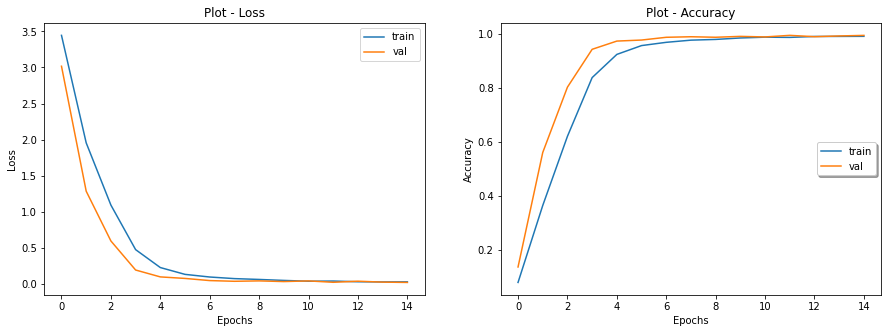

In [28]:
# Plot loss and accuracies for training and validation data

_, axs = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axs[0].plot(train_loss_list, label="train")
axs[0].plot(val_loss_list, label="val")
axs[0].set_title("Plot - Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
legend = axs[0].legend(loc='upper right', shadow=False)

# Accuracy plot
axs[1].plot(train_acc_list, label="train")
axs[1].plot(val_acc_list, label="val")
axs[1].set_title("Plot - Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
legend = axs[1].legend(loc='center right', shadow=True)

# Inference

In [29]:
# Define transformations

test_transforms = transforms.Compose([
    transforms.Resize([112, 112]),
    transforms.ToTensor()
    ])

In [30]:
test_data_path = "../input/gtsrb-german-traffic-sign/"
test_data = torchvision.datasets.ImageFolder(root = test_data_path, transform = test_transforms)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

numClasses = 43

# Generating labels of classes

num = range(numClasses)
labels = []
for i in num:
    labels.append(str(i))
labels = sorted(labels)
for i in num:
    labels[i] = int(labels[i])
print("List of labels : ")
print("Actual labels \t--> Class in PyTorch")
for i in num:
    print("\t%d \t--> \t%d" % (labels[i], i))

List of labels : 
Actual labels 	--> Class in PyTorch
	0 	--> 	0
	1 	--> 	1
	10 	--> 	2
	11 	--> 	3
	12 	--> 	4
	13 	--> 	5
	14 	--> 	6
	15 	--> 	7
	16 	--> 	8
	17 	--> 	9
	18 	--> 	10
	19 	--> 	11
	2 	--> 	12
	20 	--> 	13
	21 	--> 	14
	22 	--> 	15
	23 	--> 	16
	24 	--> 	17
	25 	--> 	18
	26 	--> 	19
	27 	--> 	20
	28 	--> 	21
	29 	--> 	22
	3 	--> 	23
	30 	--> 	24
	31 	--> 	25
	32 	--> 	26
	33 	--> 	27
	34 	--> 	28
	35 	--> 	29
	36 	--> 	30
	37 	--> 	31
	38 	--> 	32
	39 	--> 	33
	4 	--> 	34
	40 	--> 	35
	41 	--> 	36
	42 	--> 	37
	5 	--> 	38
	6 	--> 	39
	7 	--> 	40
	8 	--> 	41
	9 	--> 	42


In [31]:
import pandas as pd
# Read the image labels from the csv file
# Note: The labels provided are all numbers, whereas the labels assigned by PyTorch dataloader are strings

df = pd.read_csv("../input/gtsrb-german-traffic-sign/Test.csv")
numExamples = len(df)
labels_list = list(df.iloc[:,6])

print(numExamples)


12630


In [32]:
the_model = AlexnetTS(43)
the_model.load_state_dict(torch.load(PATH_TO_MODEL))
the_model.cuda()

AlexnetTS(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=12544, out_features=1000, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5,

In [33]:
import os
import pandas as pd

data_dir="../input/gtsrb-german-traffic-sign/Test"
test_class=os.listdir(data_dir)


df = pd.read_csv("../input/gtsrb-german-traffic-sign/Test.csv")
y_test=df['ClassId'].values
path_list =df['Path'].values

print(path_list)

['Test/00000.png' 'Test/00001.png' 'Test/00002.png' ... 'Test/12627.png'
 'Test/12628.png' 'Test/12629.png']


# Changing directory of test set such that pytorch recognises it

In [34]:
data=[]
for f in path_list:
    img = Image.open('../input/gtsrb-german-traffic-sign/Test/'+f.replace('Test/', ''))
    data_array=transforms.ToTensor()
    img_PIL = transforms.Resize([112,112])(img)
    img_ = transforms.ToTensor()(img_PIL)
    data.append(img_)

# loading test dataset

In [35]:
test_loader =torch.utils.data.DataLoader(data, batch_size=1, shuffle=False)

In [36]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
def predict_image(img, model):
    # Convert to a batch of 1
    device=torch.device('cuda')
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    print(yb)
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return preds.item()

# Testing on test dataset

In [37]:
import torch as t
y_pred_list = []
corr_classified = 0

with torch.no_grad():
    the_model.eval()
    
    i = 0
    
    for image in test_loader:
        image = image.cuda()
        
        y_test_pred = the_model(image)
        
        y_pred_softmax = t.log_softmax(y_test_pred[0], dim=1)
        _, y_pred_tags = t.max(y_pred_softmax, dim=1)
        y_pred_tags = y_pred_tags.cpu().numpy()
        
        y_pred = y_pred_tags[0]
        y_pred = labels[y_pred]
        
        y_pred_list.append(y_pred)
        
        if labels_list[i] == y_pred:
            corr_classified += 1
        
        i += 1
    
print("Correctly classified: {}".format(corr_classified))
print("Incorrectly classified: {}".format(numExamples - corr_classified))
print("Final accuracy: {}".format(corr_classified / numExamples))
    

Correctly classified: 12039
Incorrectly classified: 591
Final accuracy: 0.9532066508313539


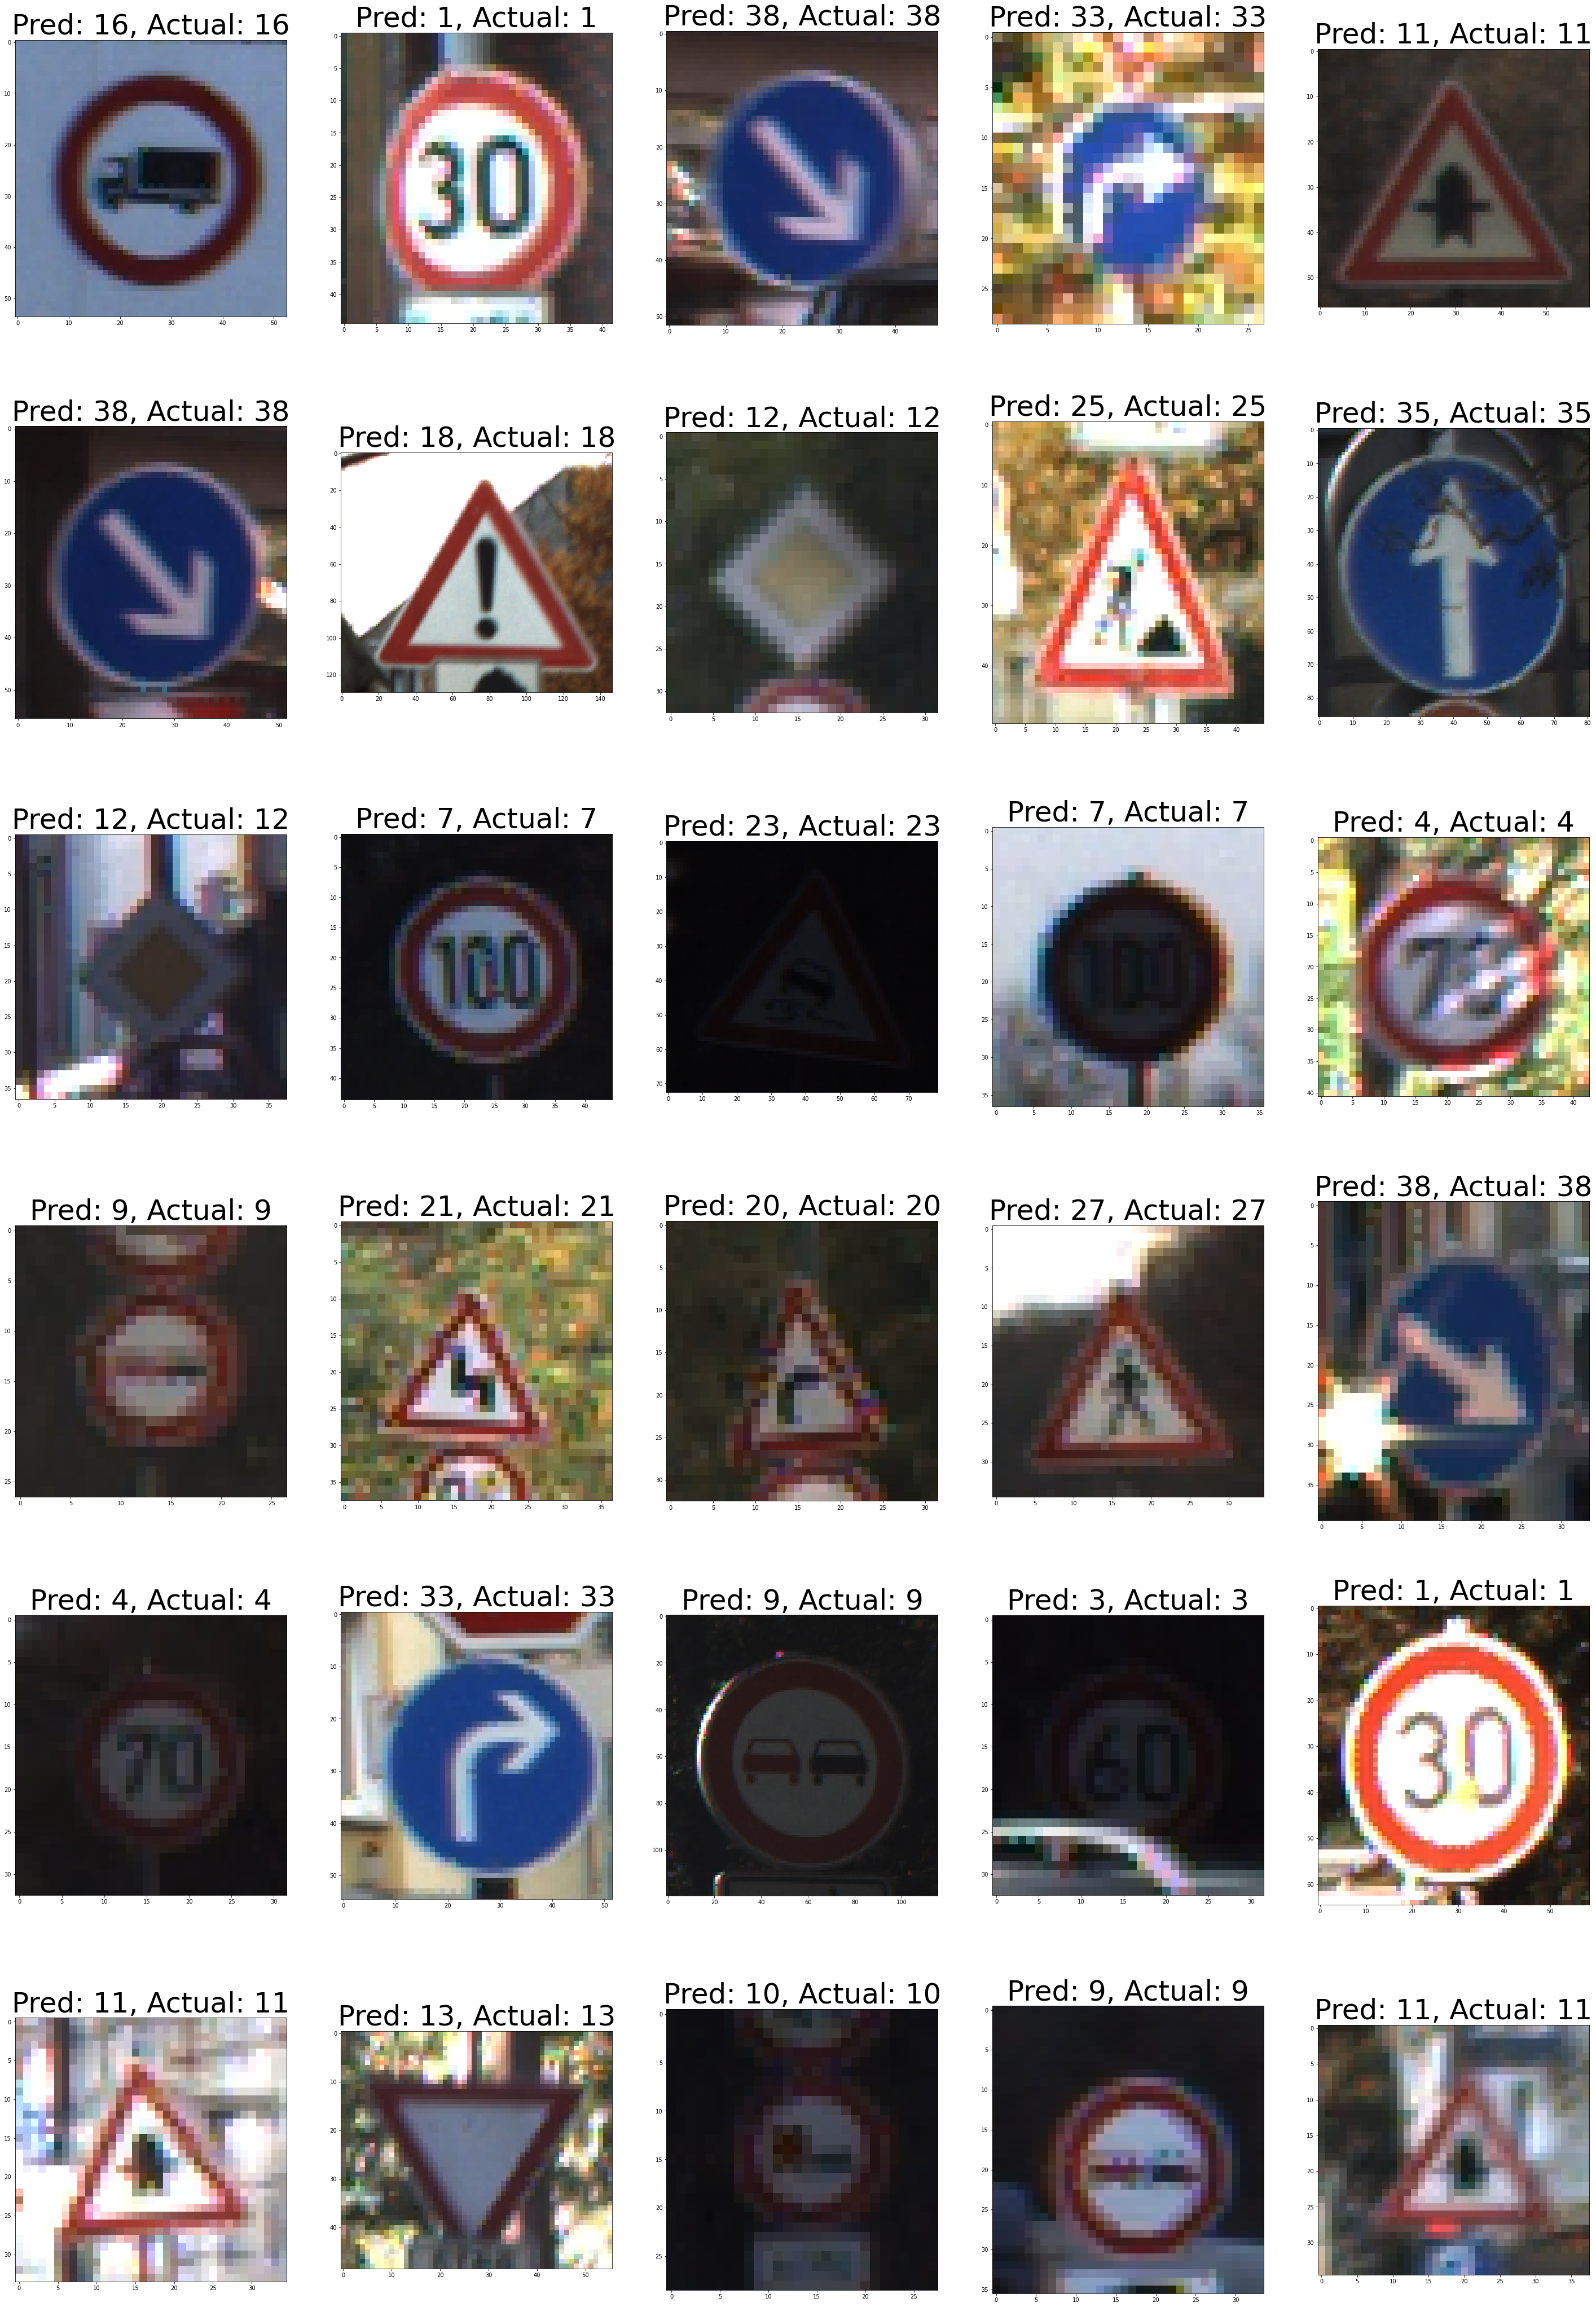

In [38]:
from PIL import Image
fig, axs = plt.subplots(6,5,figsize=(50,75))
#fig.tight_layout(h_pad = 50)
for i in range(30):
    row = i // 5
    col = i % 5
    
    imgName = "../input/gtsrb-german-traffic-sign/" + df.iloc[i,7]
    wrongFolder = str(imgName)
    #wrongExtension = wrongFolder.replace('.png', '.ppm')
    img = Image.open(wrongFolder)
    axs[row, col].imshow(img)
    title = "Pred: %d, Actual: %d" % (y_pred_list[i], labels_list[i])
    axs[row, col].set_title(title, fontsize=50)

plt.savefig("predictions.png", bbox_inches = 'tight', pad_inches=0.5)